# Real Time Eye Gaze Tracking with Kinect


In [1]:
# main tools
import cv2
import numpy as np
import pandas as pd

# utils
import os
import json
import bson
import sys
sys.path.append('../')  # for brspy

from utils import *
from pyquaternion import Quaternion
from rolling_window import rolling_window

# visualization
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from matplotlib import pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from plotly.offline import iplot

# reading brs sessions
from brspy.reader import Session

# for exporting data from BRS sessions
# from brspy.export import GazesExport
# from brspy.export import MimicsExport
# from brspy.export import JointsExport
# from brspy.export import JointOrientationsExport
# from brspy.export import FacePropertiesExport

# device utils
from devices import Camera
from devices import Device

# ML
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# load autoreload
%load_ext autoreload
%autoreload 2

## Configuration

In [2]:
# configure plot
init_notebook_mode(connected=True)
%matplotlib inline

### markers path ###
# markers_path = r'./markers.json'  # analog markers
markers_path = r'./dots.json'  # digital markers

### dataset path ###
# datasets_path = r"./datasets/07_08_18"
datasets_path = r"D:/datasets-calibration/27_08_18"

### sessions codes ###
sessions = {
    'test': [
        '1534426982',
        '1535015458', # dima test
        '1534255495', # diff head poses
    ],
    'train': [
        '1535376192',  # Rostik calibration 9 points, 100 frames (9x3)
        '1535011692',  # Dima calibration 27 points (9x3)
        '1534950051',  # Rostik calibration 27 points (9x3)
        '1533638926',  # 40 frames
        '1534255495',  # different head rotations
        '1534749770',  # "static" head rotation
    ]
}

# create session path
train_sess_path = os.path.join(datasets_path, sessions['train'][0])
test_sess_path = os.path.join(r"D:/datasets-calibration/14_08_18", sessions['test'][-1])

### camera parameters data
cam_data_path = r'./cam_data.json'

# load markers
with open(markers_path, 'r') as f:
    markers_db = json.load(f)

# load camera parameters
with open(cam_data_path, 'r') as f:
    cam_data = json.load(f)
    
test_markers = np.array([markers_db.get(f'screen_dot_{i+1}') for i in range(9)]) / 1000

marker_style={
    'mode': 'markers',
    'marker': dict(size=3, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)
}

line_style={
#     'mode': 'line',
    'marker': dict(size=3, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)
}

### Cameras 

In [3]:
for cam_name, data_dict in cam_data.items():
    Camera(cam_name, **data_dict)
    
KinectColor = Camera.get('KinectColor')
WebCamera = Camera.get('WebCamera')
InfraredCamera = Camera.get('InfraredCamera')
KinectInfrared = Camera.get('KinectInfrared')

### write markers to session

In [8]:
markers_path = r'./dots.json'
markers_save = os.path.join(train_sess_path, 'DataSource', 'cam_101')

try:
    os.mkdir(markers_save)
except:
    pass

# set snapshot counter
counter = 0

# iterate on calibration
for _ in range(((900) // 9 // 100)):
    
    # iterate on calibration points
    for i in range(9):
        
        # iterate on snapshot per calibration points
        for _ in range(100):
            
            # get point from dict
            marker = markers_db.get(f'screen_dot_{i+1}')
            
            if marker:
                
                # create file name
                file_name = os.path.join(markers_save, str(counter).rjust(5, '0') + '.txt')
                
                # write snapshot file
                with open(file_name, 'w') as f:
                    json.dump(to_json(marker, scale=1e-3), f)
                
                # update snapshot count
                counter += 1
            else:
                continue

## Create session

In [4]:
train_sess = Session(train_sess_path)
test_sess = Session(test_sess_path)

device_to_remove = [
    'KinectDepth',
    'KinectInfrared',
    'KinectBodyIndex',
    'KinectColor',
#     'KinectBody',
#     'KinectFaceVertices',
#     'GazeEstimation',
#     'WebCamera',
#     'InfraredCamera',
#     'Markers'
]

train_sess.remove_devices(*device_to_remove)
test_sess.remove_devices(*device_to_remove)

### analyse snapshot

In [122]:
def estimate_face_points_3d(snapshot, camera, cam_resolution_x=1296):
    
    pipe_left = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
    pipe_right = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
    
    # get face points
    face_points = np.array([dict_to_np(snapshot.KinectFaceVertices[str(i)]).flatten() for i in HDFace.All])
    face_points = face_points * flip_array
    
    yield face_points
    
    for eye_label in ['Left', 'Right']:
        
        # get eye indices
        EyeInnerLid = getattr(HDFace, f'{eye_label}EyeInnerLid')
        EyeInnercorner = getattr(HDFace, f'{eye_label}EyeInnercorner')
        EyeOutercorner = getattr(HDFace, f'{eye_label}EyeOutercorner')
        EyeMidtop = getattr(HDFace, f'{eye_label}EyeMidtop')
        EyeMidbottom = getattr(HDFace, f'{eye_label}EyeMidbottom')
        
        # get eye circle points
        eye_inner_lid = InfraredCamera.vectors_to_self(face_points[EyeInnerLid])
        
        # get pupil center on 2D image
        pupil_2d = dict_to_np(snapshot.GazeEstimation[f'pupilCenter{eye_label}'])
        
        # get roi points of eye
        roi = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation[f'eyeRoi{eye_label}']])
        
        # flip x-coordinate of 2D coordinates because of mirrored image
        pupil_2d[0, 0] = cam_resolution_x - pupil_2d[0, 0]
        roi[:, 0] = cam_resolution_x - roi[:, 0]
        
        # calculate relative position of pupil center on 2D image
        relative_pupil_2d = (pupil_2d - roi[0]) / np.diff(roi, axis=0)
        relative_pupil_2d[0, 0] = 1 - relative_pupil_2d[0, 0] 
        
        # estimate eye surface
        pipe = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))
        left_XY = eye_inner_lid[:, :2]
        left_Z = eye_inner_lid[:, 2]
        pipe.fit(left_XY, left_Z)
        
        # get eye corners, top and mid points
        # and transit to Interested Camera coordinate system
        inner, outer, midtop, midbot = camera.vectors_to_self(face_points[[EyeInnercorner,
                                                                            EyeOutercorner,
                                                                            EyeMidtop,
                                                                            EyeMidbottom]])
        
        # get roi points X and Y in 3D in Interested Camera coordinate system
        if eye_label is 'Left': 
            top = np.array([inner[0], midtop[1]])
            bot = np.array([outer[0], midbot[1]])
        elif eye_label is 'Right':
            bot = np.array([inner[0], midbot[1]])
            top = np.array([outer[0], midtop[1]])
    
        # get size of roi 3 roi
        size_xy = np.abs(top - bot)

        # estimate X and Y of 3D pupilcenter
        pupil_XY = top + relative_pupil_2d * size_xy

        # estimate Z of 3D pupil_center
        pupil_Z = pipe.predict(pupil_XY)
        pupil_XYZ = np.column_stack((pupil_XY, pupil_Z))

        # return pupil_center to origin coordinate system
        yield camera.vectors_to_origin(pupil_XYZ).flatten()

In [123]:
flip_array = np.array([-1, -1, 1])


def smooth(array, window):
    smoothed = pd.DataFrame(array).rolling(window).mean().values
    smoothed[:window] = array[:window]
    return smoothed

def create_trace_3d(data, **kwargs):
    
    assert data.ndim == 2
    assert data.shape[1] == 3
    
    x, y, z = data.T
    return go.Scatter3d(x=x, y=z, z=-y, **kwargs)


class EyeSession:
        
    def __init__(self, label):
        self.label = label
        self.centers = []
        self.pupils = []
        self.gazes = []
        self.v_gazes = []

        self.Innercorner = getattr(HDFace, f'{self.label}EyeInnercorner')
        self.Outercorner = getattr(HDFace, f'{self.label}EyeOutercorner')
        self.Midtop = getattr(HDFace, f'{self.label}EyeMidtop')
        self.Midbottom = getattr(HDFace, f'{self.label}EyeMidbottom')

    def calculate_features(self, face_points, rotations, translations):
        # corners

        self.inner_vector = self.pupils - face_points[:, self.Innercorner]
        self.outer_vector = self.pupils - face_points[:, self.Outercorner]

        self.midtop = vectors_to(face_points[:, self.Midtop],
                                 rotations,
                                 translations)#.reshape(-1, 10, 3).mean(axis=1)

        # vertical features
        self.midtop_vector = self.pupils - face_points[:, self.Midtop]
        self.midbot_vector = self.pupils - face_points[:, self.Midbottom]

        # lid vector
        self.lid_vector = face_points[:, self.Midtop] - face_points[:, self.Midbottom]

        self.outer_norm = np.linalg.norm(self.outer_vector, axis=1, keepdims=True)
        self.inner_norm = np.linalg.norm(self.inner_vector, axis=1, keepdims=True)
        self.midtop_norm = np.linalg.norm(self.midtop_vector, axis=1, keepdims=True)
        self.midbot_norm = np.linalg.norm(self.midbot_vector, axis=1, keepdims=True)
        self.lid_norm = np.linalg.norm(self.lid_vector, axis=1, keepdims=True)
        
        self.pupil_vvector = self.midbot_vector + self.midtop_vector
        self.pupil_hvector = self.inner_vector + self.outer_vector
        
        self.pupil_v_norm = np.linalg.norm(self.pupil_vvector, axis=1, keepdims=True)
        self.pupil_h_norm = np.linalg.norm(self.pupil_hvector, axis=1, keepdims=True)
        
        self.pupil_vvector_norm = self.pupil_vvector / self.pupil_v_norm
        self.pupil_hvector_norm = self.pupil_hvector / self.pupil_h_norm

    def to_np(self):
        self.centers = np.array(self.centers)
        self.pupils = np.array(self.pupils)
        self.gazes = np.array(self.gazes)
        self.v_gazes = np.array(self.v_gazes)
        

class FaceSession:
    
    def __init__(self, session, *args, name='session', **kwargs):
        
        self.name = name
        self.markers = []

        self.rotations = []
        self.translations = []
        
        self.left_eye = EyeSession('Left')
        self.right_eye = EyeSession('Right')
        
        self.face_points = []
        self.face_gazes = []
        
        self.session = session
        
        self._read_session(*args, **kwargs)
        
    def _read_session(self, *args, body_key='0', face_key=0, **kwargs):
        
        for snapshot in self.session.snapshots_iterate(*args, **kwargs):
            
            # get pupil and face points
            estimated_face_points_3d = estimate_face_points_3d(snapshot, InfraredCamera)
            
            # append face points
            face_points = next(estimated_face_points_3d)
            self.face_points.append(face_points)
            
            for eye in [self.left_eye, self.right_eye]:
                # append data
                eye.pupils.append(next(estimated_face_points_3d))
                
                # get eye centers
                eye_center = dict_to_np(snapshot.GazeEstimation[f'eyeSphereCenter{eye.label}']) * flip_array
                eye.centers.append(eye_center.flatten())
                
                # get victor prediction
                eye.v_gazes.append((dict_to_np(snapshot.GazeEstimation[f'gaze{eye.label}']) * np.array([1, -1, -1])).flatten())
            
            # get translation
            translation = dict_to_np(snapshot.KinectBody[body_key]['Joints']['Head']['Position']).flatten() * flip_array
            self.translations.append(translation)
            
            # get rotation
            q = snapshot.KinectFace[face_key]['FaceRotationQuaternion']
            q = Quaternion(q['W'], q['X'], q['Y'], q['Z'])
            rotation = cv2.Rodrigues(q.rotation_matrix)[0].flatten() #* flip_array
            self.rotations.append(rotation)
            
            # get marker
            try:
                marker = dict_to_np(snapshot.Markers)
                self.markers.append(marker.flatten())
            except AttributeError:
                pass
            
            # create person device
            # person = Device(name='person', translation=translation.tolist(), rotation=rotation.tolist())
        
        self.markers = np.array(self.markers)

        self.rotations = np.array(self.rotations)
        self.translations = np.array(self.translations)
        
        self.left_eye.to_np()
        self.right_eye.to_np()
        
        self.face_points = np.array(self.face_points)
        self.face_gazes = np.array(self.face_gazes)
        
    def fit(self):
        
        # calculate true gaze vectors
        if self.markers.tolist():
            
            for eye in [self.left_eye, self.right_eye]:
                eye.true_gazes = self.markers - eye.pupils

                # norm pupil vectors
                eye.true_gazes = eye.true_gazes / np.linalg.norm(eye.true_gazes, axis=1, keepdims=True)

                # true gaze self
                eye.true_gaze_self = vectors_to(eye.true_gazes, self.rotations)

                # true_gaze_self = true_gaze_self.reshape(-1, 10, 3).mean(axis=1)
                eye.true_gaze_self = eye.true_gaze_self / np.linalg.norm(eye.true_gaze_self, axis=1, keepdims=True)

                eye.calculate_features(self.face_points, self.rotations, self.translations)
        
    def estimate_gaze(self):
        pass
        
    def create_video(self,
                     end,
                     start=0,
                     victor_gaze=False,
                     face_gaze=False,
                     true_gaze=False,
                     pred_gaze=False,
                     output_path='output_test.avi',
                     fps=10.0,
                     **kwargs):
        
        flags = (true_gaze, victor_gaze, pred_gaze)
        colors = (Color.Blue, Color.Green, Color.Red)
        try:
            # Define the codec and create VideoWriter object
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            out = cv2.VideoWriter(output_path, fourcc, fps, (1280, 960))
            
            for i, snapshot in enumerate(self.session.snapshots_iterate(start, end, **kwargs)):
                # get webcam and basler images
                webcam_img = np.copy(snapshot.WebCamera[::-1, ::, :])
                ir_img = np.copy(snapshot.InfraredCamera[:, ::-1, ::])
                
                for eye in [self.left_eye, self.right_eye]:
                    
                    # draw pupil circle
                    pupil_2d = InfraredCamera.project_vectors(eye.pupils[i].reshape(1, 3))
                    cv2.circle(ir_img, tuple(pupil_2d[0].astype(int)), 3, (255, 0, 0), -1)
                    
                    for flag, vectors, color in zip(flags, (eye.true_gazes, eye.v_gazes, eye.gazes), colors):
                        if flag:
                            draw_gaze(webcam_img, 
                                      ir_img, 
                                      vectors[i], 
                                      eye.pupils[i], 
                                      test_markers[[0, 2, -1], :],
                                      color)
                
                if face_gaze:
                    draw_gaze(webcam_img,
                              ir_img,
                              self.rotations[i],
                              self.translations[i]+(self.rotations[i] * 3),
                              test_markers[[0, 2, -1], :],
                              (0, 0, 0))

                # resize infrared camera image
                ir_resized = cv2.resize(ir_img, (0, 0), fx=0.4, fy=0.4)

                # and put into webcam image
                ir_h, ir_w = ir_resized.shape[:2]
                webcam_img[-ir_h:, 0:ir_w] = ir_resized

                # write frame
                out.write(webcam_img)

        finally:
            # release writing
            out.release()
            
            
def draw_gaze(webcam_img, ir_img, gaze, pupil, plane_points, color=(255, 0, 0)):
    
    assert isinstance(pupil, np.ndarray), str(type(pupil))
    assert isinstance(gaze, np.ndarray), str(type(gaze))
    assert isinstance(color, tuple), str(type(color))
    
    # find gaze vector 3D endpoint
    gaze_vector_end = gaze / 10 + pupil

    # stack gaze lines
    gaze_line = np.vstack((pupil, gaze_vector_end))
    
    try:
        # find gaze lines intersections with screen
        gaze_point = plane_line_intersection(gaze_line, plane_points).reshape(1, 3)

        # project lines to InfraredCamera
        ir_projected_line = InfraredCamera.project_vectors(gaze_line)

        # find gaze points on webcam image
        screen_projected_point = WebCamera.project_vectors(gaze_point).flatten().astype(int)

        # draw gaze points
        cv2.circle(webcam_img, tuple(screen_projected_point), 4, color, -1)
        
    except OverflowError:
        return -1

    # draw true gaze lines
    pt1, pt2 = ir_projected_line.astype(int)
    cv2.line(ir_img, tuple(pt1), tuple(pt2), color, 3)

## Load sessions

In [104]:
train = FaceSession(train_sess, 0, 900, name='train', verbose=True)
train.fit()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [01:04<00:00, 13.88it/s]


In [124]:
test = FaceSession(test_sess, 0, 900, name='test', verbose=True)
test.fit()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [01:04<00:00, 13.88it/s]


## Explore

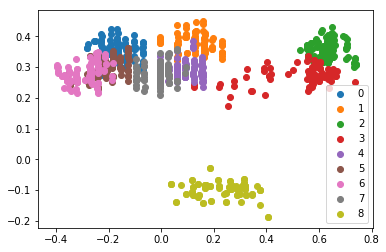

In [106]:
data = vecs2angles(train.right_eye.pupil_hvector_norm).reshape(1, 9, 100, 2)
colors_indices = [j for i in range(3) for j in range(9) for k in range(100)]

labels = [j for i in range(3) for j in range(9) for k in range(100)]

for j in range(9):
    plt.scatter(data[:, j, :, 0], data[:, j, :, 1], label=str(j))
plt.legend()

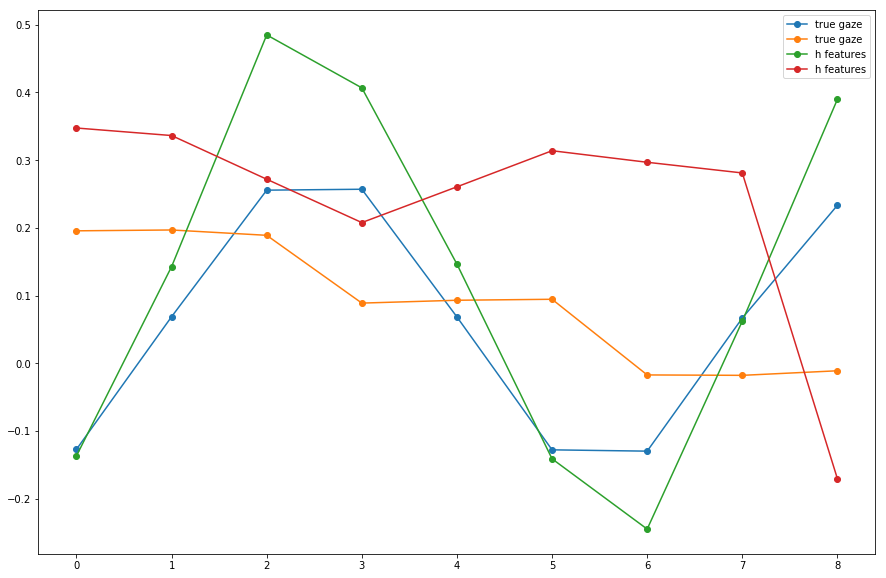

In [107]:
plt.figure(figsize=(15, 10))
plt.plot(vecs2angles(train.left_eye.true_gazes.reshape(9, 100, 3).mean(axis=1)), 'o-', label='true gaze')
plt.plot(vecs2angles(train.left_eye.pupil_hvector_norm.reshape(9, 100, 3).mean(axis=1)), 'o-', label='h features')
plt.legend()

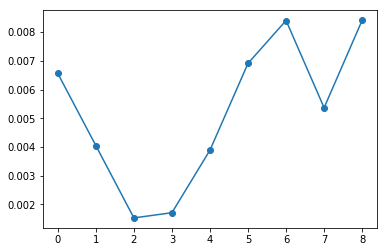

In [108]:
plt.plot(train.left_eye.pupil_v_norm.reshape(9, 100, 1).mean(axis=1), 'o-', label='v features')

## Train model

In [109]:
def create_models(poly_features=2, alpha=1e-1, normalize=True):
    for _ in range(2):
        preprocessing = (PolynomialFeatures(poly_features),)
        regression_model = MultiOutputRegressor(Ridge(alpha, normalize=True))
        yield make_pipeline(*preprocessing, regression_model)

def create_features(face_session):
    for eye in [face_session.left_eye, face_session.right_eye]:
        yield np.column_stack([vecs2angles(eye.pupil_hvector_norm), eye.pupil_v_norm])
        
def average_features(arrays, n_calibrations=9, n_frames=100):
    for array in arrays:
        assert isinstance(array, np.ndarray), str(type(array))
        assert array.ndim == 2, str(array.ndim, array.shape)
        yield array.reshape(n_calibrations, n_frames, -1).mean(axis=1)
        
def create_targets(face_session):
    for eye in [face_session.left_eye, face_session.right_eye]:
        yield vecs2angles(eye.true_gazes)

In [118]:
poly_features = 2
n_calibrations = 9
n_frames = 100

# create model
pipe_left, pipe_right = create_models(poly_features=2, alpha=1e-1, normalize=True)

# get data
X_raw_left, X_raw_right = create_features(train)
Y_raw_left, Y_raw_right = create_targets(train)

arrays = iter((X_raw_left, X_raw_right, Y_raw_left, Y_raw_right))
X_train_left, X_train_right, Y_train_left, Y_train_right = average_features(arrays,
                                                                            n_calibrations=n_calibrations,
                                                                            n_frames=n_frames)

split = 7

# fit models
pipe_left.fit(X_train_left, Y_train_left)
pipe_right.fit(X_train_right, Y_train_right)

print(calc_angle_spherical(pipe_left.predict(X_train_left), Y_train_left).mean(axis=0))
print(calc_angle_spherical(pipe_right.predict(X_train_right), Y_train_right).mean(axis=0))

train.left_eye.gazes = angles2vecs(pipe_left.predict(smooth(X_raw_left, 10)))
train.right_eye.gazes = angles2vecs(pipe_left.predict(smooth(X_raw_right, 10)))

1.903645174860271
2.1471590939763034


In [119]:
train.create_video(900,
                   verbose=True,
                   victor_gaze=False,
                   face_gaze=True,
                   true_gaze=True,
                   pred_gaze=True,
                   fps=30,
                   output_path='output_train_smoo_rostik_100frames.avi')

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [01:13<00:00, 12.31it/s]


## Test model

In [120]:
X_test_left, X_test_right = create_features(test)
# Y_test_left, Y_test_right = create_targets(test)


test.left_eye.gazes = angles2vecs(pipe_left.predict(smooth(X_test_left, 5)))
test.right_eye.gazes = angles2vecs(pipe_left.predict(smooth(X_test_right, 5)))

In [121]:
test.create_video(900,
                  victor_gaze=False,
                  face_gaze=True,
                  true_gaze=True,
                  pred_gaze=True,
                  verbose=True,
                  fps=15,
                  output_path='output_test_rostik_diff_heads.avi')

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [01:11<00:00, 12.59it/s]


Text(0,0.5,'Angle error, degree')

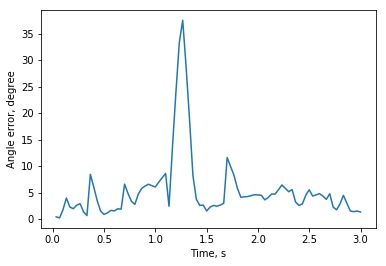

In [87]:
angle_err = calc_angle_3d(test.right_eye.true_gazes, test.right_eye.gazes)
x_time = np.arange(1, 91) / 30
plt.plot(x_time, angle_err)

plt.xlabel('Time, s')
# plt.xticks(np.arange(0, 10))
plt.ylabel('Angle error, degree')

## Check calibration points

[[153.78511375 104.44225223]
 [390.96767959 104.80564946]
 [599.93897742 104.85091871]
 [604.2017778  227.01410877]
 [398.99984171 234.5367799 ]
 [167.34151633 243.00166754]
 [180.09835292 375.72450418]
 [406.6984885  359.37375538]
 [608.06163273 344.88471418]]


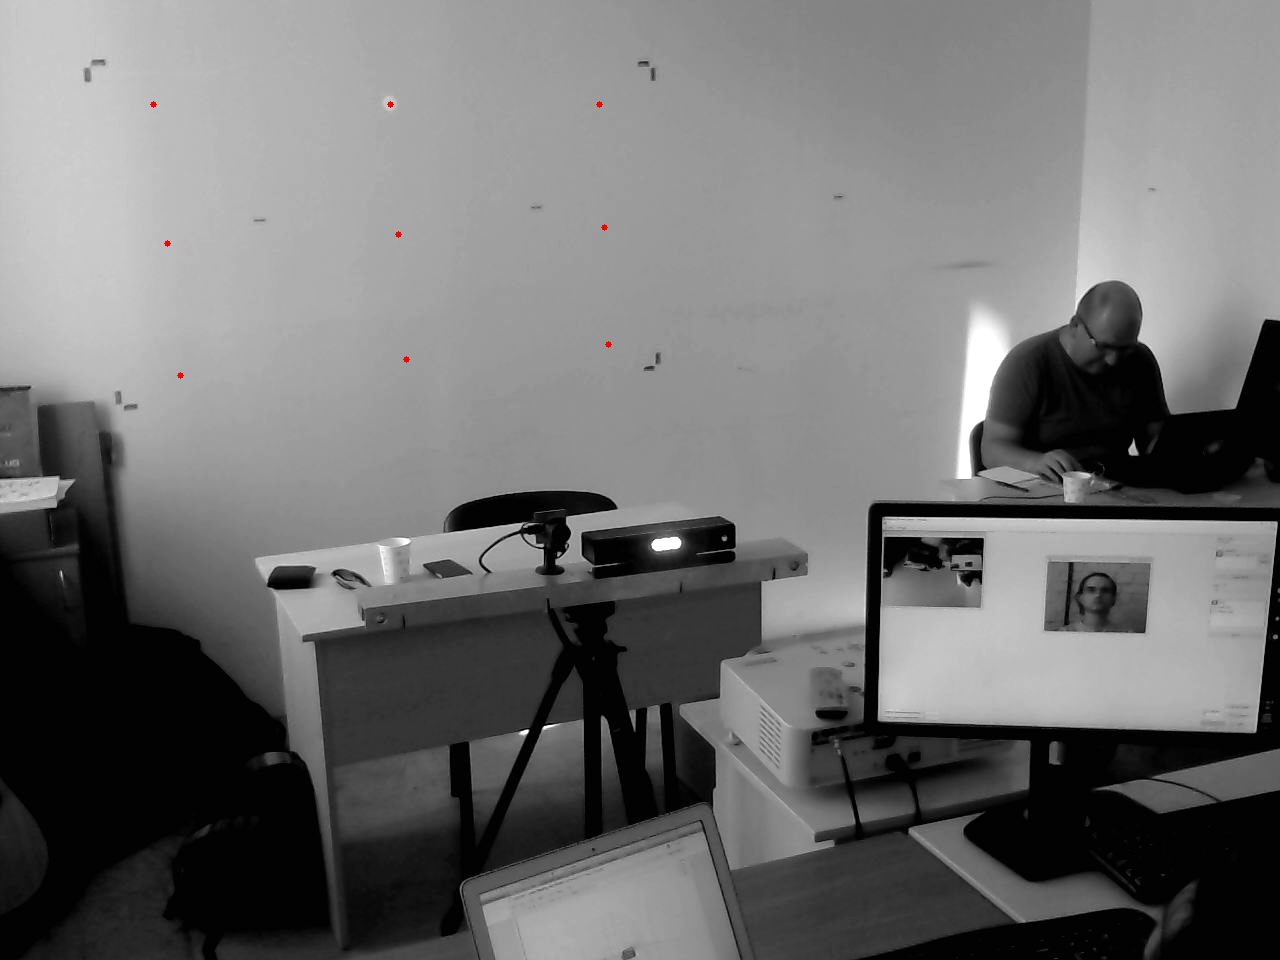

In [63]:
img = np.copy(train_sess.read_snapshot(100).WebCamera[::-1, ::, :])

calibration_points_3d = test_markers

# get point in 2d
calibration_points_2d = WebCamera.project_vectors(calibration_points_3d)
print(calibration_points_2d)

for point in calibration_points_2d:
    cv2.circle(img, tuple(point.astype(int)), 3, (255, 0, 0), -1)
    
# cv2.circle(img, tuple(calibration_points_2d[-1].astype(int)), 3, (0, 255, 0), -1)
Image.fromarray(img)